<a href="https://colab.research.google.com/github/RasKrebs/aml_itu/blob/devs/notebooks/tiny_vgg_v1_w_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Setup`

In [3]:
import pandas as pd
import numpy as np
import os
import albumentations as A
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

Mounted at /content/drive
Cloning into 'aml_itu'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 160 (delta 0), reused 1 (delta 0), pack-reused 144
Receiving objects: 100% (160/160), 177.83 MiB | 34.43 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/aml_itu
/content/aml_itu
No GPU available, using CPU instead


### `Config`

In [5]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/imgs/train',
   'test': '/content/drive/MyDrive/aml-distracted-drivers-project/state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `TinyVGG`

In [34]:
# IMG Transformations
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)])


val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)])


# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))
# target_transform = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(int(y.replace('c', ''))), value=1))

In [35]:
# Creating the dataset
train_data = StateFarmDataset(config, transform=train_transforms, split='train', target_transform=target_transform)
val_data = StateFarmDataset(config, split='test', transform=val_transforms, target_transform=target_transform)

In [36]:
train_data.img_labels = train_data.img_labels
train_data.metadata.target.value_counts(True)

safe driving                    0.108135
texting - left                  0.104815
talking on the phone - right    0.103985
talking on the phone - left     0.103486
drinking                        0.102656
operating the radio             0.102380
texting - right                 0.101051
talking to passenger            0.097399
reaching behind                 0.088268
hair and makeup                 0.087825
Name: target, dtype: float64

In [37]:
val_data.img_labels = val_data.img_labels
val_data.img_labels.classname.value_counts(True)

c0    0.122876
c6    0.107947
c5    0.106109
c4    0.104731
c3    0.103813
c1    0.101286
c2    0.100597
c7    0.093477
c9    0.084750
c8    0.074414
Name: classname, dtype: float64

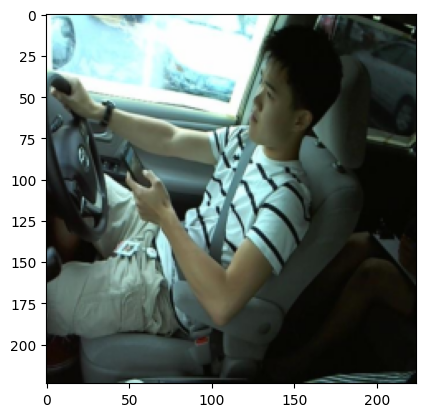

In [38]:
img, _ = train_data[100]
plt.imshow(img.permute(1, 2, 0))

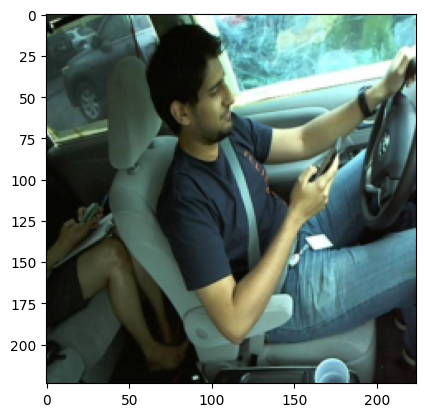

In [39]:
img, _ = val_data[100]
plt.imshow(img.permute(1, 2, 0))

#### `Model`

In [47]:
class TinyVGG(torch.nn.Module):
    def __init__(self,
                filters = 32,
                num_classes = 10,
                kernel_size = (3,3),
                stride = 1,
                in_channels = 3,
                pool_kernel_size = (2,2)):
        """TinyVGG Model"""

        super(TinyVGG, self).__init__()

        # First Convolution Block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels = filters,
                      kernel_size=kernel_size,
                      stride=stride),
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.Conv2d(in_channels=filters,
                      out_channels = filters,
                      kernel_size=kernel_size,
                      stride=stride),
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.MaxPool2d(kernel_size = pool_kernel_size))

        # Second Convolution Block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=filters,
                      out_channels = filters,
                      kernel_size=kernel_size,
                      stride=stride),
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.Conv2d(in_channels=filters,
                      out_channels = filters,
                      kernel_size=kernel_size,
                      stride=stride),
            nn.ReLU(),
            nn.BatchNorm2d(filters),
            nn.MaxPool2d(kernel_size = pool_kernel_size))

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*53*53,
                      out_features=num_classes))


    def forward(self, x):
        # Pass the data through the convolutional blocks
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # Pass through the fully connected layer
        x = self.fc(x)

        return x

In [48]:
# Instantiating the model
model = TinyVGG()

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in

In [49]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [51]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 110, 110]        --
│    └─Conv2d: 2-1                       [32, 32, 222, 222]        896
│    └─ReLU: 2-2                         [32, 32, 222, 222]        --
│    └─BatchNorm2d: 2-3                  [32, 32, 222, 222]        64
│    └─Conv2d: 2-4                       [32, 32, 220, 220]        9,248
│    └─ReLU: 2-5                         [32, 32, 220, 220]        --
│    └─BatchNorm2d: 2-6                  [32, 32, 220, 220]        64
│    └─MaxPool2d: 2-7                    [32, 32, 110, 110]        --
├─Sequential: 1-2                        [32, 32, 53, 53]          --
│    └─Conv2d: 2-8                       [32, 32, 108, 108]        9,248
│    └─ReLU: 2-9                         [32, 32, 108, 108]        --
│    └─BatchNorm2d: 2-10                 [32, 32, 108, 108]        64
│    └─C

In [53]:
forward = model(x)

In [60]:
assert forward.shape == (32,10)

#### `Training Loop`

In [61]:
def train_step(
    model,
    dataloader,
    loss_fn,
    optimizer,
    device):
    """Train step for a single epoch"""
    # Set model to train mode
    model.train()

    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        # Move data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        out = model(X)
        loss = loss_fn(out, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (out.argmax(1) == y).type(torch.float).mean().item()

    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [62]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Set model to eval mode
    print('Validation loop')
    model.eval()

    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculatio
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            # Move data to device
            X, y = X.to(device), y.to(device)

            # Forward pass and update validation loss
            out = model(X)
            loss = loss_fn(out, y)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (out.argmax(1) == y).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [63]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Loop through epochs
    for epoch in range(epochs):
        # Training
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        print(f'Training Epoch {epoch+1} Done')
        # Validation
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)

        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print info
        print(f"Epoch {epoch+1} of {epochs} - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")

In [64]:
# Set random seeds
torch.manual_seed(42)


# Recreate an instance of TinyVGG
model = TinyVGG().to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

# Train model_0
model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        validation_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs,
                        device=device)

NameError: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/aml-distracted-drivers-project')